In [2]:
import os
import numpy as np
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
!pip install -i https://pypi.org/simple scikit-learn
!pip install -i https://pypi.org/simple numba

In [3]:
# Data preparation
dataset_dir= r"C:\Users\m1355\Documents\WeChat Files\wxid_z0qpzwe8erfg22\FileStorage\File\2023-06\crc_skin_data\crc_skin_data"
input_shape=(224, 224, 3)
batch_size=8
num_classes=2

In [4]:
#Data augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen=ImageDataGenerator(
    rescale=1./255)

In [5]:
#Generate the train dataset, validation dataset and test dataset
train_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary', #skin has two classes: benign and malignant
    subset='training')

validation_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary', #skin has two classes: benign and malignant
    subset='validation')

test_generator=test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary' #skin has two classes: benign and malignant
)

Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
# Load pre-trained VGG model without the top layers
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers so they are not updated during training
for layer in vgg16.layers:
    layer.trainable = False

# Create a new model and add the VGG base model
model = Sequential()
model.add(vgg16)

# Add additional layers for classification
model.add(Flatten())
model.add(Dense(512, activation='relu'))  # First additional FC layer
model.add(Dense(256, activation='relu'))  # Second additional FC layer
model.add(Dense(1, activation='sigmoid'))  # Final FC layer

In [7]:
#compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [8]:
#Train the model
history=model.fit(train_generator, epochs=5, validation_data=(validation_generator), verbose=1)

Epoch 1/5
50/50 [==============================] - 9s 81ms/step - loss: 0.8758 - accuracy: 0.6850 - val_loss: 0.4974 - val_accuracy: 0.7700
Epoch 2/5
50/50 [==============================] - 3s 70ms/step - loss: 0.4633 - accuracy: 0.7975 - val_loss: 0.6208 - val_accuracy: 0.6900
Epoch 3/5
50/50 [==============================] - 3s 68ms/step - loss: 0.3882 - accuracy: 0.8150 - val_loss: 0.5508 - val_accuracy: 0.7600
Epoch 4/5
50/50 [==============================] - 3s 61ms/step - loss: 0.3225 - accuracy: 0.8575 - val_loss: 0.5997 - val_accuracy: 0.7500
Epoch 5/5
50/50 [==============================] - 3s 66ms/step - loss: 0.2998 - accuracy: 0.8725 - val_loss: 0.9875 - val_accuracy: 0.6400


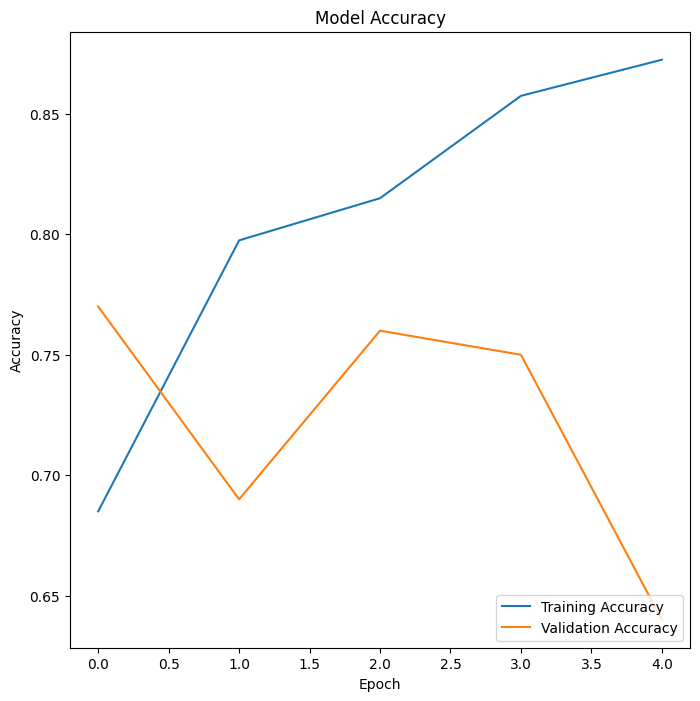

In [9]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')
plt.show()

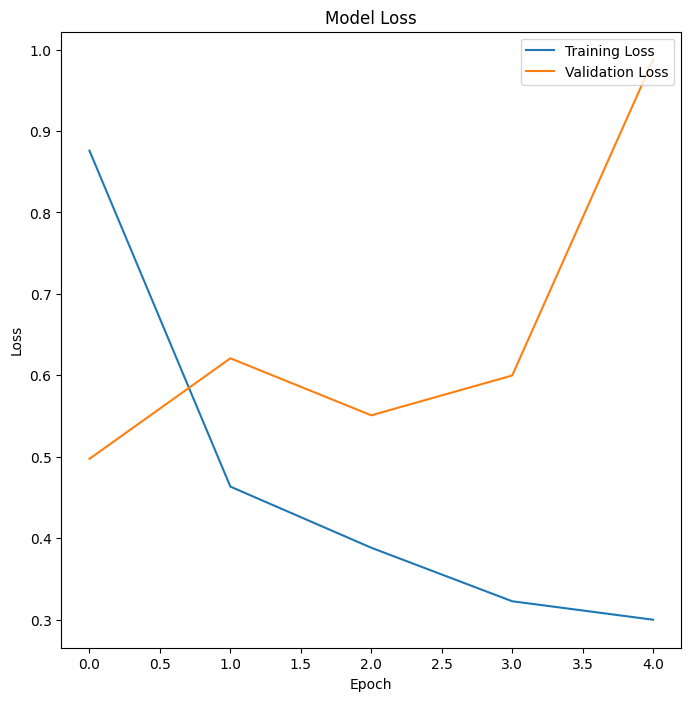

In [10]:
#Trainig loss and validation loss graph
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')
plt.show()

In [11]:
# Evaluate the model on the testing dataset
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

13/13 [==============================] - 0s 30ms/step - loss: 0.6671 - accuracy: 0.7500
Test loss: 0.6671182513237
Test accuracy: 0.75


In [12]:
#Compute confusion matrix
from sklearn.metrics import confusion_matrix

#Generate predictions for the test dataset
y_pred=model.predict(test_generator)
y_pred_labels= (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

#compute the confusion matrix
confusion= confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:")
print(confusion)

13/13 [==============================] - 0s 27ms/step
Confusion Matrix:
[[33 17]
 [42  8]]


In [13]:
#compute f1-score
from sklearn.metrics import f1_score

f1=f1_score(y_true, y_pred_labels)
print('F1-score:', f1)

F1-score: 0.21333333333333335


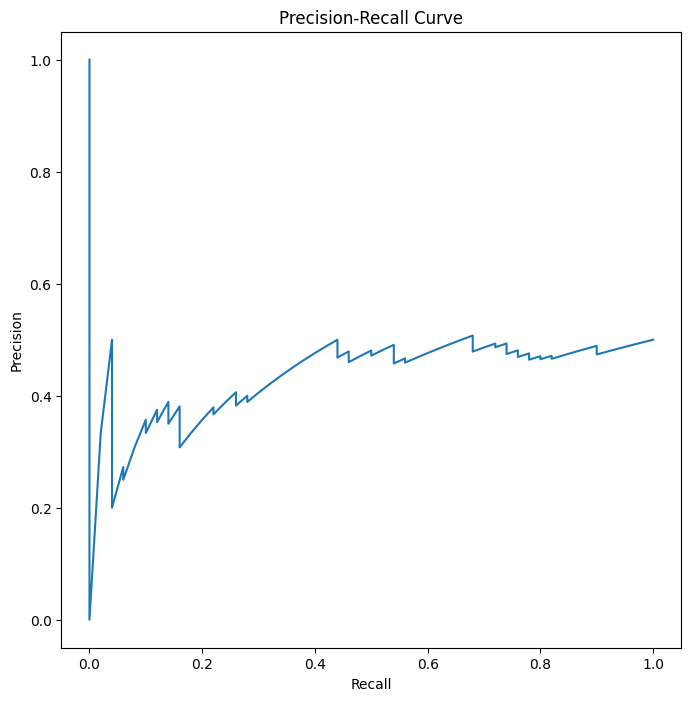

In [14]:
#compute precision-recall score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#compute precision, recall(sensitivity), and threshold values
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

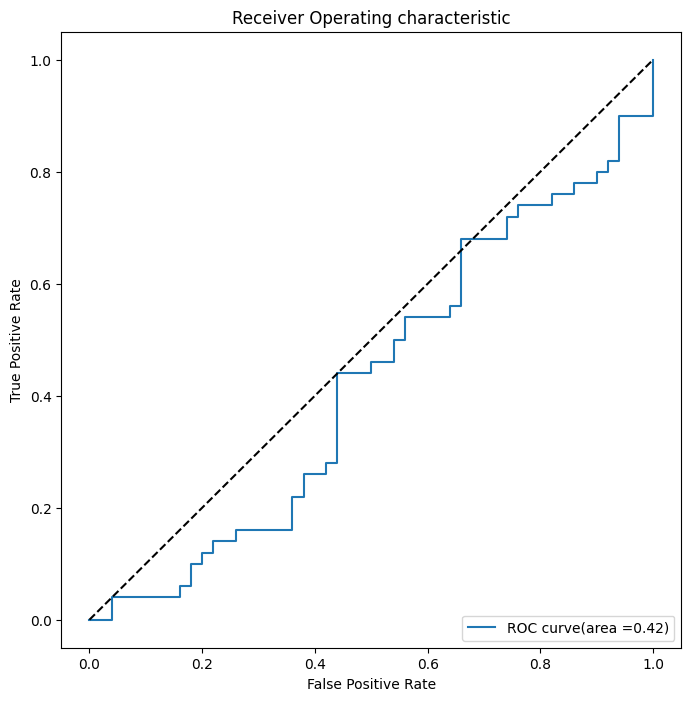

In [15]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [16]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.0
specificity: 0.98


In [17]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model



In [18]:
#You need to install numba using 'pip install numba'

from numba import cuda

cuda.select_device(0)
cuda.close()